In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [28]:
from matplotlib import rcParams
# 设置中文字体
rcParams['font.sans-serif'] = ['SimHei']  # 指定黑体（或其他支持中文的字体）
rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

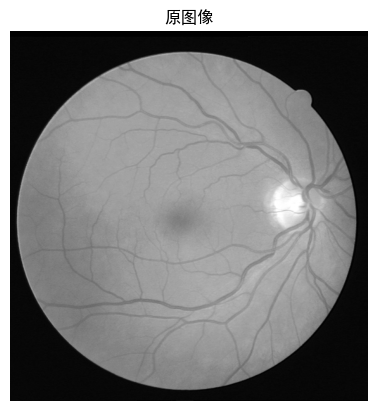

In [ ]:
# 加载图像
image = cv2.imread('GT/C.png', cv2.IMREAD_GRAYSCALE)
# 显示结果
plt.imshow(image, cmap='gray')
plt.title('原图像')
plt.axis('off')
plt.show()

#### 2.1 图像反转
图像反转是通过将每个像素的灰度值进行反转来改变图像的对比度。例如，对于灰度图像，反转操作将原图像的亮区转为暗区，暗区转为亮区。这可以突出血管区域，因为血管通常比背景亮。

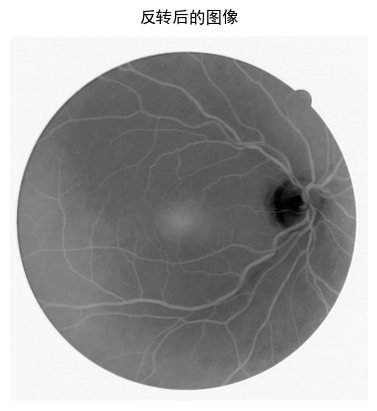

In [30]:


# 图像反转
inverted_image = 255 - image

# 显示结果
plt.imshow(inverted_image, cmap='gray')
plt.title('反转后的图像')
plt.axis('off')
plt.show()

#### 2.3 幂律（伽马）变换
伽马变换通过调整图像的亮度，使得图像的高亮区域更亮，暗区域更暗。这有助于增强血管区域。

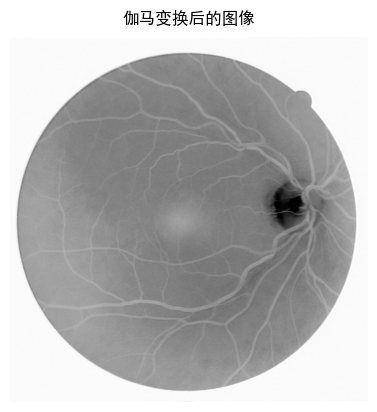

In [31]:
gamma = 0.55  # 伽马值
gamma_transformed = np.power((255-image) / 255.0, gamma) * 255

# 显示伽马变换结果
plt.imshow(gamma_transformed, cmap='gray')
plt.title('伽马变换后的图像')
plt.axis('off')
plt.show()

### 3. 空间滤波
空间滤波操作通常用于图像的平滑（低通滤波）和锐化（高通滤波），它们有助于增强图像的局部特征

#### 3.1 低通滤波（平滑）
低通滤波器通常用于去除图像中的噪声，使得血管轮廓更加平滑。常用的低通滤波器有 均值滤波器 和 高斯滤波器。

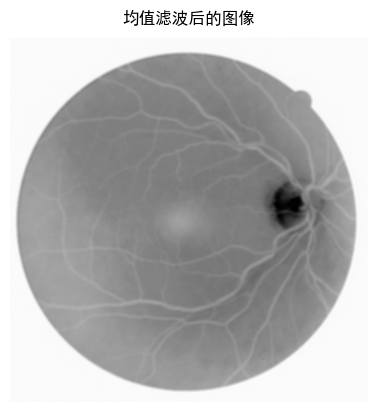

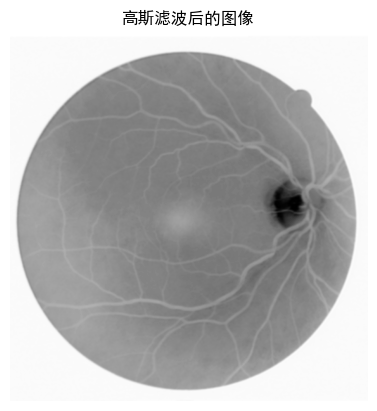

In [32]:
# 均值滤波
kernel = np.ones((5, 5), np.float32) / 25
smoothed_image = cv2.filter2D(gamma_transformed, -1, kernel)

# 显示平滑后的图像
plt.imshow(smoothed_image, cmap='gray')
plt.title('均值滤波后的图像')
plt.axis('off')
plt.show()

# 高斯滤波
gaussian_blurred = cv2.GaussianBlur(gamma_transformed, (5, 5), 0)

# 显示高斯滤波后的图像
plt.imshow(gaussian_blurred, cmap='gray')
plt.title('高斯滤波后的图像')
plt.axis('off')
plt.show()

#### 3.2 高通滤波（锐化）
高通滤波器常用于突出图像中的边缘特征，例如血管的边界。常用的高通滤波器有 拉普拉斯滤波器 和 Sobel算子。

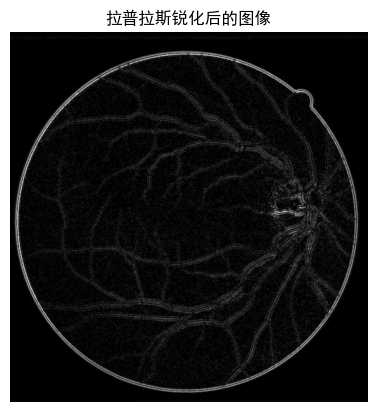

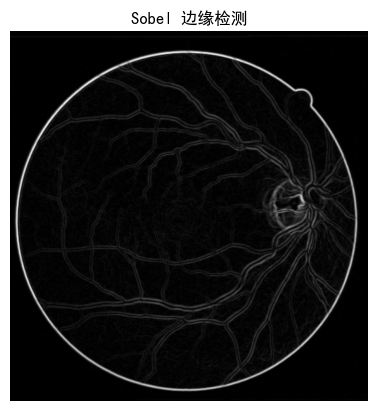

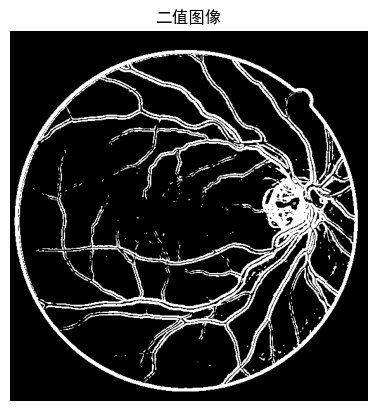

In [33]:
# 拉普拉斯滤波器
laplacian = cv2.Laplacian(gaussian_blurred, cv2.CV_64F)
laplacian = cv2.convertScaleAbs(laplacian)

# 显示拉普拉斯滤波结果
plt.imshow(laplacian, cmap='gray')
plt.title('拉普拉斯锐化后的图像')
plt.axis('off')
plt.show()

limg=laplacian+image;
# Sobel 边缘检测
sobel_x = cv2.Sobel(gaussian_blurred, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gaussian_blurred, cv2.CV_64F, 0, 1, ksize=3)
sobel_edges = cv2.magnitude(sobel_x, sobel_y)

# 将幅值归一化到0-255范围
sobel_edges = np.uint8(np.abs(sobel_edges))

# 对边缘图像进行二值化（阈值化）
_, binary_edges = cv2.threshold(sobel_edges, 15, 255, cv2.THRESH_BINARY)

# 显示 Sobel 边缘图像
plt.imshow(sobel_edges, cmap='gray')
plt.title('Sobel 边缘检测')
plt.axis('off')
plt.show()

# 显示 Sobel 边缘图像
plt.imshow(binary_edges, cmap='gray')
plt.title('二值图像')
plt.axis('off')
plt.show()


### 4. 形态学操作
形态学处理有助于进一步增强或分割血管区域，例如通过腐蚀、膨胀等操作来去除小的噪声或者连接断开的血管部分。

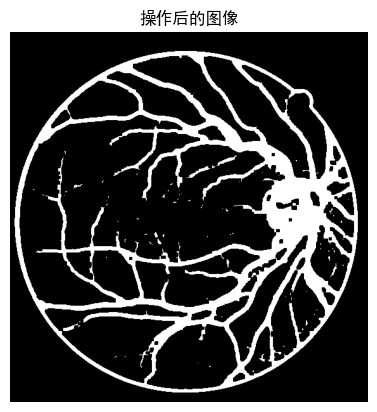

In [34]:
# 结构元素
kernel = np.ones((5, 5), np.uint8)

# 步骤2: 使用形态学操作来去噪并提取血管结构
kernel = np.ones((5, 5), np.uint8)
dilated = cv2.dilate(binary_edges, kernel, iterations=1)  # 膨胀操作
eroded = cv2.erode(dilated, kernel, iterations=1)  # 腐蚀操作

# 显示膨胀后的图像
plt.imshow(eroded, cmap='gray')
plt.title('操作后的图像')
plt.axis('off')
plt.show()

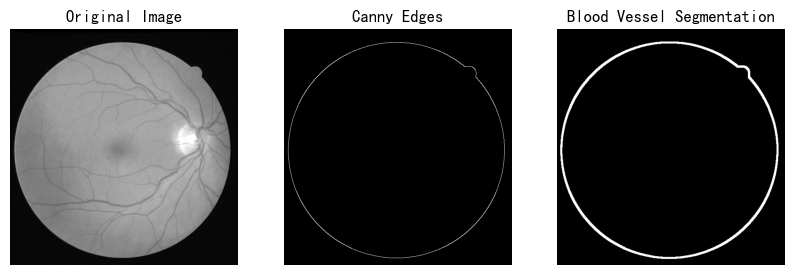

In [35]:
# 步骤1: 应用 Canny 边缘检测
edges = cv2.Canny(cv2.convertScaleAbs(gaussian_blurred), threshold1=15, threshold2=255)



# 步骤2: 使用形态学操作来去噪并提取血管结构
kernel = np.ones((5, 5), np.uint8)
dilated = cv2.dilate(edges, kernel, iterations=2)  # 膨胀操作
eroded = cv2.erode(dilated, kernel, iterations=1)  # 腐蚀操作

# 步骤3: 显示处理后的图像
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(eroded, cmap='gray')
plt.title('Blood Vessel Segmentation')
plt.axis('off')

plt.show()


## 血管专用图像增强算法

基于光谱吸收特性的血管增强算法：

该算法根据血管对光谱的吸收特性，通过减少红光谱反射和增加蓝绿光谱反射来突出血管与组织的对比度。算法包括细节增强和亮度增强两个方面。首先，通过导向滤波从彩色图像中获取RGB通道，并将其分为高动态范围的亮度层和包含细节图像信息的细节层。然后，基于信噪比（SNR）对每个通道的细节层进行自适应增强，并对亮度层进行拉伸，增强GB通道信息并减少R通道信息。最终，将细节增强图像和亮度增强图像合并，生成增强后的图像。
多颜色空间的血管增强方法：

该方法根据内窥镜血管图像的特点，提出了一种非线性对比度拉伸的多颜色空间血管增强方法。首先，在RGB颜色空间中，通过非线性映射函数对绿色通道（G）进行对比度拉伸。然后，根据G通道的拉伸结果调整红色（R）和蓝色（B）两个通道的灰度值。接着，将图像转换到HSV颜色空间，并对比度拉伸饱和度（S）分量。最后，将图像转换回RGB颜色空间，实现血管增强。该方法对小血管的增强效果较好，与其他增强方法相比，增强后的图像细节方差（DV）显著增大。
基于Hessian矩阵的Frangi血管增强方法：

该方法利用Hessian矩阵提取血管特征，并通过一系列参数抑制噪声和非血管结构。Hessian矩阵是图像二阶导数的矩阵，能够反映图像的局部曲率信息。Frangi滤波器的实现步骤包括图像预处理、Hessian矩阵计算、特征值分析、血管响应函数计算、参数选择和滤波操作。参数选择对增强效果有较大影响，包括尺度参数、对比度参数和边缘响应参数。
基于光谱变换的血管增强算法：

该算法通过增强图像的G、B分量和降低R分量，使得组织背景和血管的色调产生明显的对比效果。通过导向滤波使得各个通道的亮度层和细节层分离，并对包含血管特征的细节层进行增强，以及通过拉伸亮度层使得总体的G、B分量增加，R分量降低，进一步增强了图像的对比度。